# Installation des packages

# Préparation des données

In [1]:
from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv
import pandas as pd

landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

# Codes ISO-2 et ISO-3 relatifs aux pays

In [2]:
codesISO_data = dc.get_ISOcodes(codesISO_url)
codesISO_data = dcl.clean_ISOData(codesISO_data)
codesISO_data.to_csv("a")

# PIB Réel

L'API permet de récupérer des données sur les pays via leurs codes ISO avec 2 lettres
Exemple : "FR" pour la France, "DE" pour l'Allemagne, "GB" pour le Royaume-Uni, etc.

In [3]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
PIB_Reel_data = wb.get_indicator("PIB_reel", liste_pays, start=1990, end=2024)

PIB_Reel_data

,country,date,PIB
0,Afghanistan,2024,NaN
1,Afghanistan,2023,1.567265e+10
2,Afghanistan,2022,1.532523e+10
3,Afghanistan,2021,1.634520e+10
4,Afghanistan,2020,2.062196e+10
...,...,...,...
6750,Zimbabwe,1994,1.775729e+10
6751,Zimbabwe,1993,1.625602e+10
6752,Zimbabwe,1992,1.608687e+10
6753,Zimbabwe,1991,1.768090e+10


Il y a des problèmes avec les correspondances de noms entre les codes ISO et les noms des pays dans le dataframe PIB_reel_data
# Faire correspondre les noms des pays à la liste des ISO

In [4]:
PIB_countries = set(PIB_Reel_data["country"].unique())
ISO_countries = set(codesISO_data["Pays"].unique())

matching_dictionnary = {}

# Récupérer les pays avec un seul mot dans leur nom
single_word_countries = set(PIB_Reel_data[PIB_Reel_data['country'].str.split().str.len() == 1]['country'].tolist())
ISO_complicated_word_countries = ISO_countries 
potential_matching_complicated_word_countries = PIB_countries 

# Premier algorithme de matching basé sur les pays où les noms n'ont pas des caractères bizarres mais juste plusieurs mots
solved_ISO_complicated_word_countries = set()
solved_potential_matching_word_countries = set()

for iso_country in ISO_complicated_word_countries:
    for pib_country in potential_matching_complicated_word_countries:
        if iso_country in pib_country or pib_country in iso_country:
            matching_dictionnary[pib_country] = iso_country
            solved_ISO_complicated_word_countries.add(iso_country)
            solved_potential_matching_word_countries.add(pib_country)
            

# Afficher les pays non résolus après le premier algorithme
unresolved_ISO_countries = ISO_complicated_word_countries - solved_ISO_complicated_word_countries
unresolved_potential_matching_countries = potential_matching_complicated_word_countries - solved_potential_matching_word_countries

# Résoudre les derniers problèmes

for pib_country in unresolved_potential_matching_countries:
    for iso_country in unresolved_ISO_countries:
        # Je n'ai pas besoin des caractères après la virgule pour les pays problématiques.
        pib_country = pib_country.split(',')[0]
        
        if pib_country[:5] == iso_country[:5]:
            matching_dictionnary[pib_country] = iso_country
            break
        
# Résoudre les problèmes des Congos manuellement
          
matching_dictionnary['Congo, Dem. Rep.'] = 'Congo (the Democratic Republic of the)'
matching_dictionnary['Congo, Rep.'] = 'Congo (the)[k]'
matching_dictionnary['Turkiye'] = 'Türkiye[ag]'
matching_dictionnary['Korea, Rep.'] = 'Korea (the Republic of)[u]'
matching_dictionnary['Korea, Dem. People\'s Rep.'] = 'Korea (the Democratic People\'s Republic of)[t]'
matching_dictionnary['Venezuela, RB'] = 'Venezuela (Bolivarian Republic of)'

In [5]:
# Matcher maintenant les pays aux ISO

ISO_matching_dictionnary = {}
for i in range(len(codesISO_data)):
    line = codesISO_data.iloc[i]
    ISO_matching_dictionnary[line["Pays"]] = line["ISO-3"]
    
ISO_matching_dictionnary

for key in matching_dictionnary.keys():
    matching_dictionnary[key] = ISO_matching_dictionnary[matching_dictionnary[key]]
    
matching_dictionnary

{'Moldova': 'MDA',
 'Estonia': 'EST',
 'Guatemala': 'GTM',
 'Rwanda': 'RWA',
 'Cuba': 'CUB',
 'Mauritius': 'MUS',
 'Belgium': 'BEL',
 'Russian Federation': 'RUS',
 'Lesotho': 'LSO',
 'Benin': 'BEN',
 'India': 'IND',
 'Chad': 'TCD',
 'Serbia': 'SRB',
 'United States': 'USA',
 'Belize': 'BLZ',
 'Cambodia': 'KHM',
 'Fiji': 'FJI',
 'Timor-Leste': 'TLS',
 'Costa Rica': 'CRI',
 'Myanmar': 'MMR',
 'Ethiopia': 'ETH',
 'Chile': 'CHL',
 'Egypt, Arab Rep.': 'EGY',
 'Finland': 'FIN',
 'Belarus': 'BLR',
 'Lithuania': 'LTU',
 'Somalia, Fed. Rep.': 'SOM',
 'Iceland': 'ISL',
 'Uruguay': 'URY',
 'Honduras': 'HND',
 'Kenya': 'KEN',
 'Denmark': 'DNK',
 'Equatorial Guinea': 'GIN',
 'Guinea': 'GNB',
 'Palau': 'PLW',
 'New Zealand': 'NZL',
 'Syrian Arab Republic': 'SYR',
 'Latvia': 'LVA',
 'Guyana': 'GUY',
 'Mexico': 'MEX',
 'Sweden': 'SWE',
 'Ireland': 'GBR',
 'Eritrea': 'ERI',
 'Viet Nam': 'VNM',
 'Greece': 'GRC',
 'Armenia': 'ARM',
 'Morocco': 'MAR',
 'China': 'CHN',
 'Suriname': 'SUR',
 'Liberia': 'LBR'

In [6]:
PIB_Reel_data["country"] = PIB_Reel_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
PIB_Reel_data


,country,date,PIB
0,AFG,2024,NaN
1,AFG,2023,1.567265e+10
2,AFG,2022,1.532523e+10
3,AFG,2021,1.634520e+10
4,AFG,2020,2.062196e+10
...,...,...,...
6750,ZWE,1994,1.775729e+10
6751,ZWE,1993,1.625602e+10
6752,ZWE,1992,1.608687e+10
6753,ZWE,1991,1.768090e+10


# Valeurs manquantes

In [7]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.


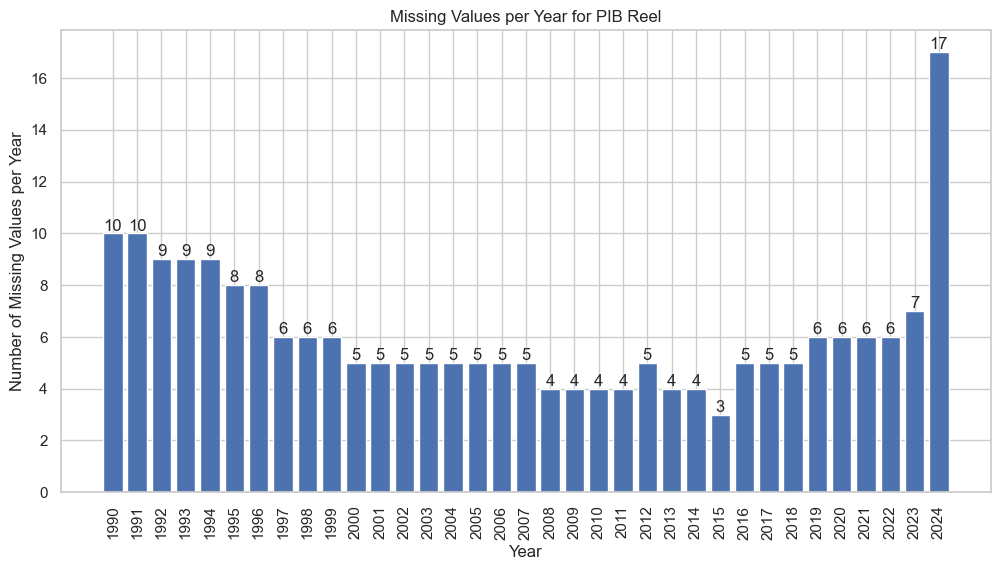

In [8]:
# Là on va checker d'où viennent les valeurs manquantes

# On va d'abord faire une analyse par date pour voir si c'est ça qui cause le problème

dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

In [9]:
# C'est bizarre qu'en 2024 il y ait plus de valeurs manquantes en 2024. Vérifions les pays dont les valeurs sont manquantes en 2024
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

# faire un commentaire
# Ce qu'on peut probablement faire c'est de l'imputation de données manquantes en utilisant la moyenne des valeurs des années précédentes pour chaque pays.
# Mais cela ne peut se faire que si on est dans des années qui sont intérieures c'est-à dire à partir de la première année omù il n'y a pas de valeur manquante

,country,date,PIB
0,AFG,2024,NaN
910,BTN,2024,NaN
1435,CUB,2024,NaN
1820,ERI,2024,NaN
3255,KOR,2024,NaN
3360,LBN,2024,NaN
3500,LIE,2024,NaN
3745,MCO,2024,NaN
4830,PLW,2024,NaN
4935,PRK,2024,NaN


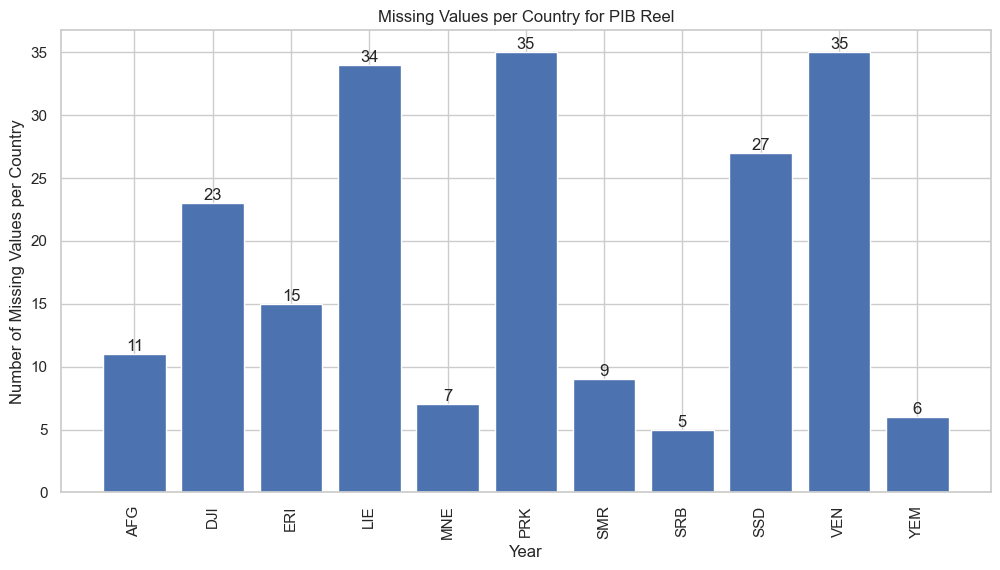

In [10]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

In [11]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)
da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 216 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 3.20% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 178 pays de 1990 à 2024.
Il y a 9 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.14% de valeurs manquantes dans la base de données.


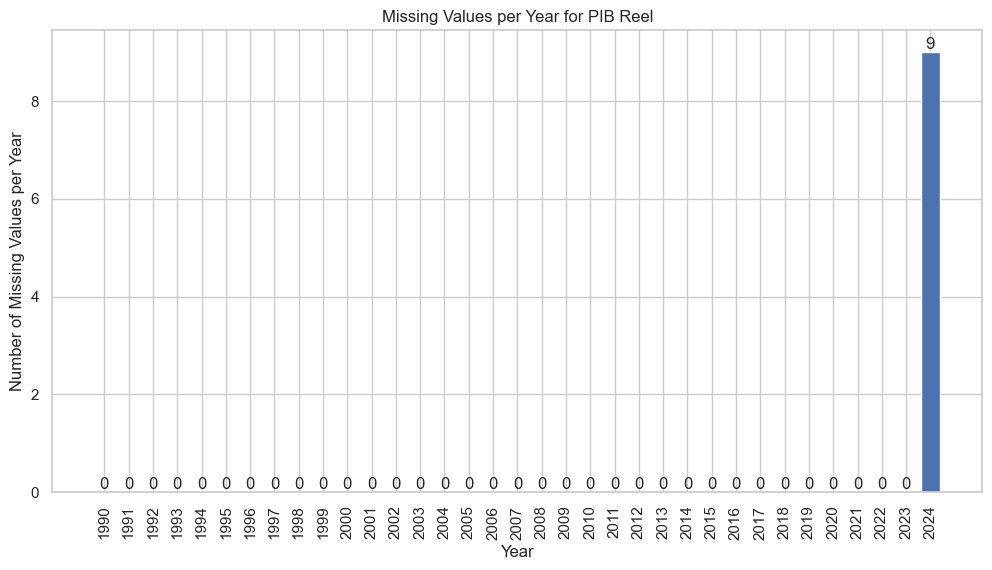

In [12]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

In [13]:
# La majeure partie des valeurs manquantes sont en 2024. On peut les imputer avec la moyenne des années précédentes.
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")
PIB_Reel_data_final

Le dataframe contient des données temporelles relatives à 178 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


,country,date,PIB
0,AGO,2024,8.959422e+10
1,AGO,2023,8.579857e+10
2,AGO,2022,8.488345e+10
3,AGO,2021,8.237534e+10
4,AGO,2020,8.139919e+10
...,...,...,...
6365,ZWE,1994,1.775729e+10
6366,ZWE,1993,1.625602e+10
6367,ZWE,1992,1.608687e+10
6368,ZWE,1991,1.768090e+10


## Description du PIB

## Evolution du PIB mondial

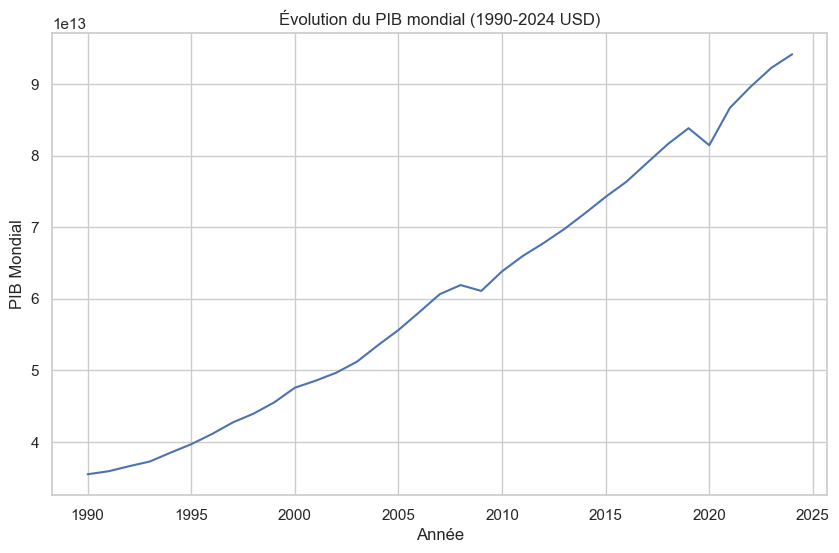

In [14]:
## Description du PIB
import matplotlib.pyplot as plt
dv.plot_world_PIB(PIB_Reel_data_final)

# Faire un commentaire

# Analyse des PIB de pays par quartiles 

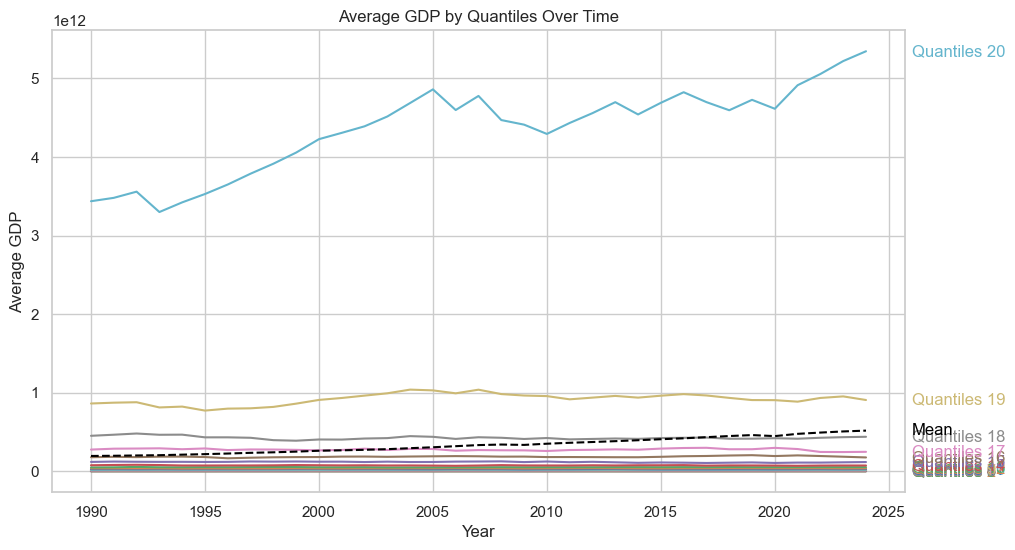

In [15]:
dv.plot_PIB_quantile(PIB_Reel_data_final)


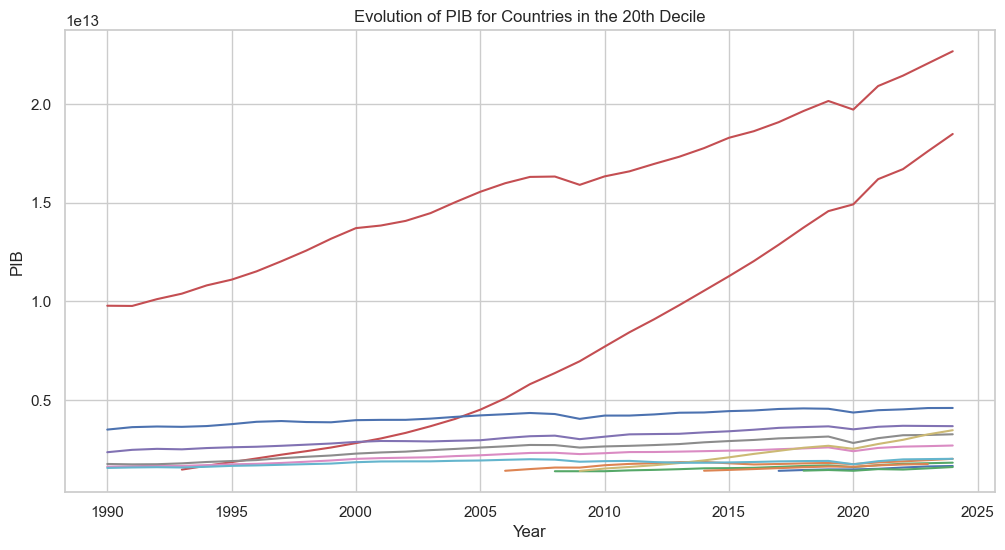

Countries in the 20th-decile: ['AUS' 'BRA' 'CAN' 'CHN' 'DEU' 'ESP' 'FRA' 'GBR' 'IND' 'ITA' 'JPN' 'KOR'
 'RUS' 'USA']


In [16]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final)

Faire un commentaire sur le fait que ce soient les pays les plus développés qui apparaissent dans ce graphique

# Ajout de la variable symbolisant la taille du pays dans l'économie mondiale

In [17]:
dump = PIB_Reel_data_final.groupby(['country','date']).sum().apply(lambda x: 100*x/PIB_Reel_data_final.groupby("date")["PIB"].sum()).reset_index() # Associer à chaque pays son poids dans l'économie mondiale par année
dump.rename(columns={"PIB":"weightCountry"},inplace=True)
weightCountry = dump.groupby(['country']).mean()['weightCountry'].reset_index() 
weightCountry.rename(columns={"weightCountry":"avgWeightCountry"},inplace=True)

weightCountry.sort_values(by="avgWeightCountry",ascending=False)

,country,avgWeightCountry
170,USA,26.409606
31,CHN,10.542865
79,JPN,7.344783
43,DEU,5.376389
56,GBR,4.707450
...,...,...
144,STP,0.000334
102,MHL,0.000311
84,KIR,0.000272
121,NRU,0.000156


# Clustering

On sépare en 4 clusters. Très Bas, Bas, Haut, Très Haut. On fait tourner les kmeans et on remarque les USA sont en tête suivi par la Chine. Ce qui correspond bien à la réalité. Faire d'autre commentaires ensuite.

In [18]:
dv.visualize_economicPower_clusters(weightCountry)


# Temps de reprise des pays après une crise

In [27]:
little_test = PIB_Reel_data_final[PIB_Reel_data_final["country"] == "BEN"].sort_values('date').reset_index(drop=True).copy()


import pandas as pd
import numpy as np

def peak_to_breach_times(df_country):

    # Sort by year and reset index
    df = df_country.sort_values('date').reset_index(drop=True).copy()
    
    df['prev_pib'] = df['PIB'].shift(1)
    df['next_pib'] = df['PIB'].shift(-1)
    df['is_peak'] = (df['PIB'] > df['prev_pib']) & (df['PIB'] > df['next_pib'])
    
    peak_indices = df.index[df['is_peak']].tolist()
    
    times = []
    
    for i in peak_indices:
        peak_year = df.loc[i, 'date']
        peak_val = df.loc[i, 'PIB']
        
        # data after the peak
        after_thePeak = df.loc[i+1:].copy()
        if after_thePeak.empty:
            continue
        
        # Require that there is a drop below the peak at some point
        if not (after_thePeak['PIB'] < peak_val).any():
            # No crisis/drawdown after this peak -> ignore
            continue
        
        # First year where PIB goes strictly above the peak again
        breached = after_thePeak[after_thePeak['PIB'] > peak_val]
        if breached.empty:
            # Never recovers above that peak in the sample
            continue
        
        breach_year = breached['date'].iloc[0]
        time_to_breach = breach_year - peak_year
        times.append(time_to_breach)
    
    mean_time = np.mean(times) if len(times) > 0 else np.nan
    return times, mean_time

peak_to_breach_times(little_test)


([], nan)